## Part a: Laser Doppler Anemometry (11 points)
### a)
The characteristic response time of a particle is $\tau=\frac{2}{9}a^{2}\frac{|{\rho_p - \rho_f}|}{\mu}$. We plot this as a function of the particle radius.

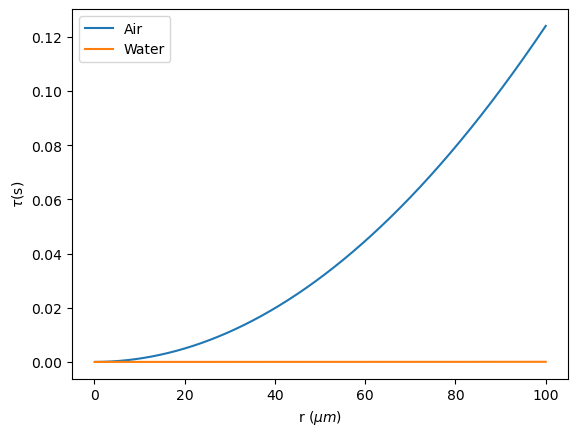

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

rho = 1.02 #g/cm^3
rho_tracers = (rho/1000)*(1e6) #kg/m^3
rho_air = 1.225 #kg/m^3
rho_water = 1000 #kg/m^3
mu_air = 1.825e-5
mu_water = 1.0005e-3
rmin = 100e-9
rmax = 100e-6

r = np.linspace(rmin, rmax, 1000)
rho_f = rho_air
mu = mu_air
tau_air = ((2/9)*(r**2)*abs(rho_tracers-rho_f))/mu
beta = 3*rho_f/(rho_f+2*rho_tracers)
St_air = r**2/(3*beta*(mu**2))

rho_f = rho_water
mu = mu_water
tau_water = ((2/9)*(r**2)*abs(rho_tracers-rho_f))/mu
beta = 3*rho_f/(rho_f+2*rho_tracers)
St_water = r**2/(3*beta*(mu**2))

plt.figure()
plt.plot(r*(10**6), tau_air, label='Air')
plt.plot(r*(10**6), tau_water, label='Water')
plt.xlabel('r ($\mu m$)')
plt.ylabel(r'$\tau$(s)')
plt.legend()
plt.show()


In [10]:
print('For air St=', np.min(St_air), np.max(St_air))
print('For water St=', np.min(St_water), np.max(St_water))

For air St= 0.005558870323634551 5558.870323634552
For water St= 3.374402531645499e-09 0.0033744025316454996


### a2)
The particles have the lowest response time in water, which means they accurately follow the flow and are thus more suitable to use in water, although for small radii the response time in air and water is about the same. In air one might wish to use other tracers with a smaller radius or density. Other types of tracer particles include: Tracers with fluorescent dye, which makes the particles easier to see. Tracers with a different refractive index, which influences the scattering cross section or tracers with a reflective coating to improve visibility.

### a3)
DO WE NEED TO DO A PARTICLE RATE CORRECTION?
\
\
In order to find the velocity of the particle in the measurement volume, we first find the signal burst. We then analyse the frequency spectrum of the burst and find its maximum. From this we can find the velocity of the particle using:\
$f_D = \frac{2\sin{\Theta/2}}{\lambda_b}v_{p,\bot}$\
We assume the tracer particles have a size of 100$nm$ and the density given in exercise a1, this means that the response time is small enough that we can approximate $v_p=v_{flow}$.\
We use the fft function from a previous homework set.

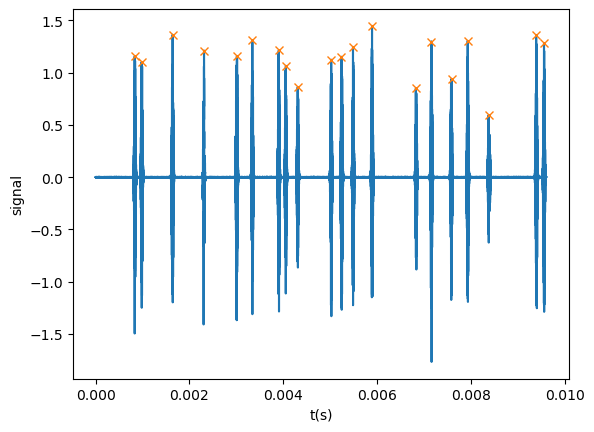

In [18]:
def bartlett_fft(signal, fs, n_pieces):
    # Cut the signal into n equally-sized pieces
    signal_list = np.split(signal, n_pieces)
    P_list = []

    # Calculate power spectrum of each piece
    for piece in signal_list:
        P_list.append(np.abs(np.fft.fft(piece))**2)

    # Calculate the average power spectrum
    P_av = np.mean(P_list, axis=0)

    # Calculate the frequency array
    f = np.fft.fftfreq(piece.size, 1/fs)
    idx = np.argsort(f)

    # Get only positive frequencies
    f, P_av = f[idx], P_av[idx]

    return f, P_av

# load data and plt
arr = np.loadtxt("LDA-signal.csv",
                 delimiter=",",skiprows=1)
t = arr[:,1]
signal = arr[:,2]

angle = 9*(2*np.pi/360) #angle to radians
lam = 488e-9
width = 600
whalf = 300
peaks, _ = find_peaks(signal, height=0.5, distance=600)

plt.figure()
plt.plot(t, signal)
plt.plot(t[peaks], signal[peaks], "x")
plt.xlabel('t(s)')
plt.ylabel('signal')
plt.title('Signal with detected peaks')
plt.show()

We now take each burst and analyse the frequency spectrum to find the velocities.

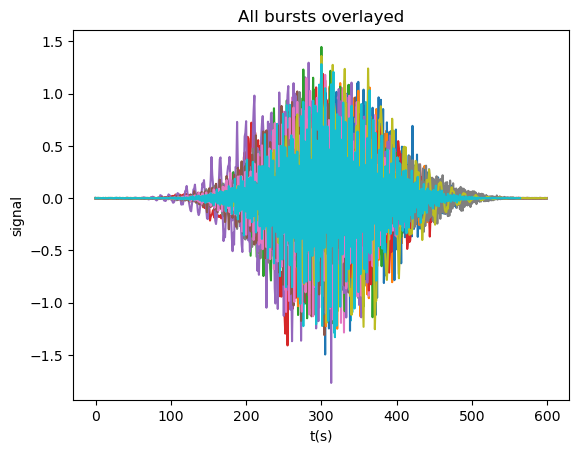

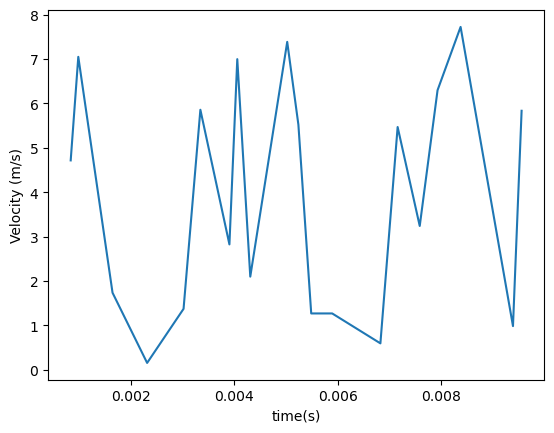

In [20]:
#take each burst and analyse the frequency spectrum
V = np.zeros(0)
T = np.zeros(0)
for i in peaks:
    #find burst signal
    burst = signal[i-whalf:i+whalf]
    
    plt.figure(4)
    plt.plot(burst)
    plt.title('All bursts overlayed')
    plt.xlabel('t(s)')
    plt.ylabel('signal')
    
    #frequency spectrum analysis
    fs = 1/(t[1]-t[0])     # Hz
    n_pieces = 1
    f, PS = bartlett_fft(burst, fs, n_pieces)
    
    #find most powerful frequency
    ind = np.argmax(PS) #find peak
    fD = abs(f[ind])
    
    
    vp = fD*lam/(2*np.sin(angle/2))
    #v = vp/(1-np.exp(-t[i]/tau_air[0]))
    V = np.append(V, vp)
    T = np.append(T, t[i])
plt.show()
plt.figure(3)
plt.plot(T, V)
plt.xlabel('time(s)')
plt.ylabel('Velocity (m/s)')
plt.show()

As we can see above, the velocity seems to rise and fall in larger peaks. It is perhaps cyclical....

### a4)
The measurement volume is (according to the handbook):\
$V_0=\frac{4}{3}\pi a_o b_o c_o$, with $a_0 = \frac{d_{w1}/2}{\cos{\Theta/2}}$, $b_0=\frac{d_{w1}}{2}$, $c_0=\frac{d_{w1}/2}{\sin{\Theta/2}}$ and $d_{w1}=\frac{4f\lambda_b}{\pi d_{w0}}$

In [17]:
#calculation
dw0 = 4e-3
f = 1
dw1 = 4*f*lam/(np.pi*dw0)
a0 = (dw1/2)/(np.cos(angle/2))
b0 = dw1/2
c0 = (dw1/2)/(np.sin(angle/2))
V0 = (4/3)*np.pi*a0*b0*c0
print(f'The measurement volume is {round(V0*(10**9), 5)} mm^3')

The measurement volume is 0.02509 mm^3
